In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
import random
import joblib
import sys
sys.path.append('/PhD/rehabilitation/小论文/论文3/同济坐站角度相位预测')
from utilss.common_utils import printlog, make_dir
from utilss.processing_tools.processing import tj_movement_classification_sample_segmentation, data_nomalize, \
    save_scaler
from IPython.display import clear_output as clear
from sklearn.model_selection import KFold
from utilss.common_utils import calculate_samples_per_class, calculate_class_weights
from sklearn.model_selection import StratifiedShuffleSplit

In [19]:
### 参数设置
## 1. 原始文件路径
raw_file_path = os.path.join(os.getcwd(), 'TJRawData')
## 2. 受试者和运动类型设置
# subjects_list_global = list(['EgH-1','EgH-2','EgH-3','EgH-4','EgH-5','EgH-6','EgH-7'])
subjects_list_global = list(['EgP-4-IMU'])
# subjects_list_global = list(['EgP-1-2','EgP-2-2','EgP-3-2','EgP-4-2','EgP-5-2','EgP-6-2','EgP-7-2'])  ##'EgP-1-2-44',EgH-2-44
phases_list_global = ['phase 0', 'phase 1', 'phase 2', 'phase 3']
## 3. 所使用的原始数据中emg、IMU和关节角度的文件（列）名
imu_names =['骨盆 Rot X,', '骨盆 Rot Y,', '骨盆 Rot Z,', '左 大腿 Rot X,' ,'左 大腿 Rot Y,',
 '左 大腿 Rot Z,' ,'左 胫骨 Rot X,' ,'左 胫骨 Rot Y,', '左 胫骨 Rot Z,' ,'左 脚 Rot X,',
 '左 脚 Rot Y,','左 脚 Rot Z,' ,'右 大腿 Rot X,' ,'右 大腿 Rot Y,' ,'右 大腿 Rot Z,',
 '右 胫骨 Rot X,', '右 胫骨 Rot Y,' ,'右 胫骨 Rot Z,' ,'右 脚 Rot X,', '右 脚 Rot Y,',
 '右 脚 Rot Z,']
print(len(imu_names))
imu_indices = {name: idx +1 for idx, name in enumerate(imu_names)}
# # print("ss",emg_indices,imu_indices)
# angle_indices = {
#     '髋关节屈曲 左,deg': 17,
#     '髋关节屈曲 右,deg': 18,
#     '膝关节屈曲 左,deg': 19,
#     '膝关节屈曲 右,deg': 20,
#     '踝关节背屈 左,deg': 21,
#     '踝关节背屈 右,deg': 22,
# }
## 3. 所使用的原始数据中emg、IMU和关节角度的文件（列）名
angle_names = ['髋关节屈曲 左,deg',  '膝关节屈曲 左,deg',  '踝关节背屈 左,deg',
              ]
# print("ss",emg_indices,imu_indices)
angle_indices = {
    '髋关节屈曲 左,deg': 17,
    '膝关节屈曲 左,deg': 19,
    '踝关节背屈 左,deg': 21,
}
# print(angle_indices)
## 4. 由于使用的是post数据，除了归一化不再做多余的处理
# post数据中，EMG信号在20 Hz下进行高通滤波（六阶巴特沃斯），在350 Hz下进行低通滤波（六阶巴特沃斯），在6、60和180 Hz下进行陷波滤波（六阶巴特沃斯，300 Hz宽度），以衰减运动伪影和环境干扰。
# 测角仪和IMU信号分别在10和25 Hz下进行低通滤波（六阶巴特沃斯）。
data_normalize_method = 'positive_negative_one'  # 支持：'min-max' （0-1之间），'max-abs' (-1,1之间)，'positive_negative_one' （-1，1之间）
data_normalize_level = 'rows'  # 'matrix' （矩阵层面，使用整个矩阵的最大值最小值来对每一列进行操作，这样保持了每种模态信号的相对幅值），
# 'rows' （列层面，使用每一列（通道）的最大值最小值来对每一列进行操作，即每一列都被单独归一化）
## 5. 重叠窗口采样：重叠窗长， 步进长度
window, step = 32, 16  ## 重叠长度为：window-step：32-16,64-32,128-64,256-128)
win=3216
## 6. 其他设置
raw_emg_fs = 2000
raw_imu_fs = 2000
target_fs = 1000
print(str(win))

21
3216



================================================================================2025-02-26 11:08:30
开始处理： EgP-4-IMU
['Time,s' '骨盆 Rot X,' '骨盆 Rot Y,' '骨盆 Rot Z,' '左 大腿 Rot X,' '左 大腿 Rot Y,'
 '左 大腿 Rot Z,' '左 胫骨 Rot X,' '左 胫骨 Rot Y,' '左 胫骨 Rot Z,' '左 脚 Rot X,'
 '左 脚 Rot Y,' '左 脚 Rot Z,' '右 大腿 Rot X,' '右 大腿 Rot Y,' '右 大腿 Rot Z,'
 '右 胫骨 Rot X,' '右 胫骨 Rot Y,' '右 胫骨 Rot Z,' '右 脚 Rot X,' '右 脚 Rot Y,'
 '右 脚 Rot Z,']
(27075, 21)
CSV 文件已保存！


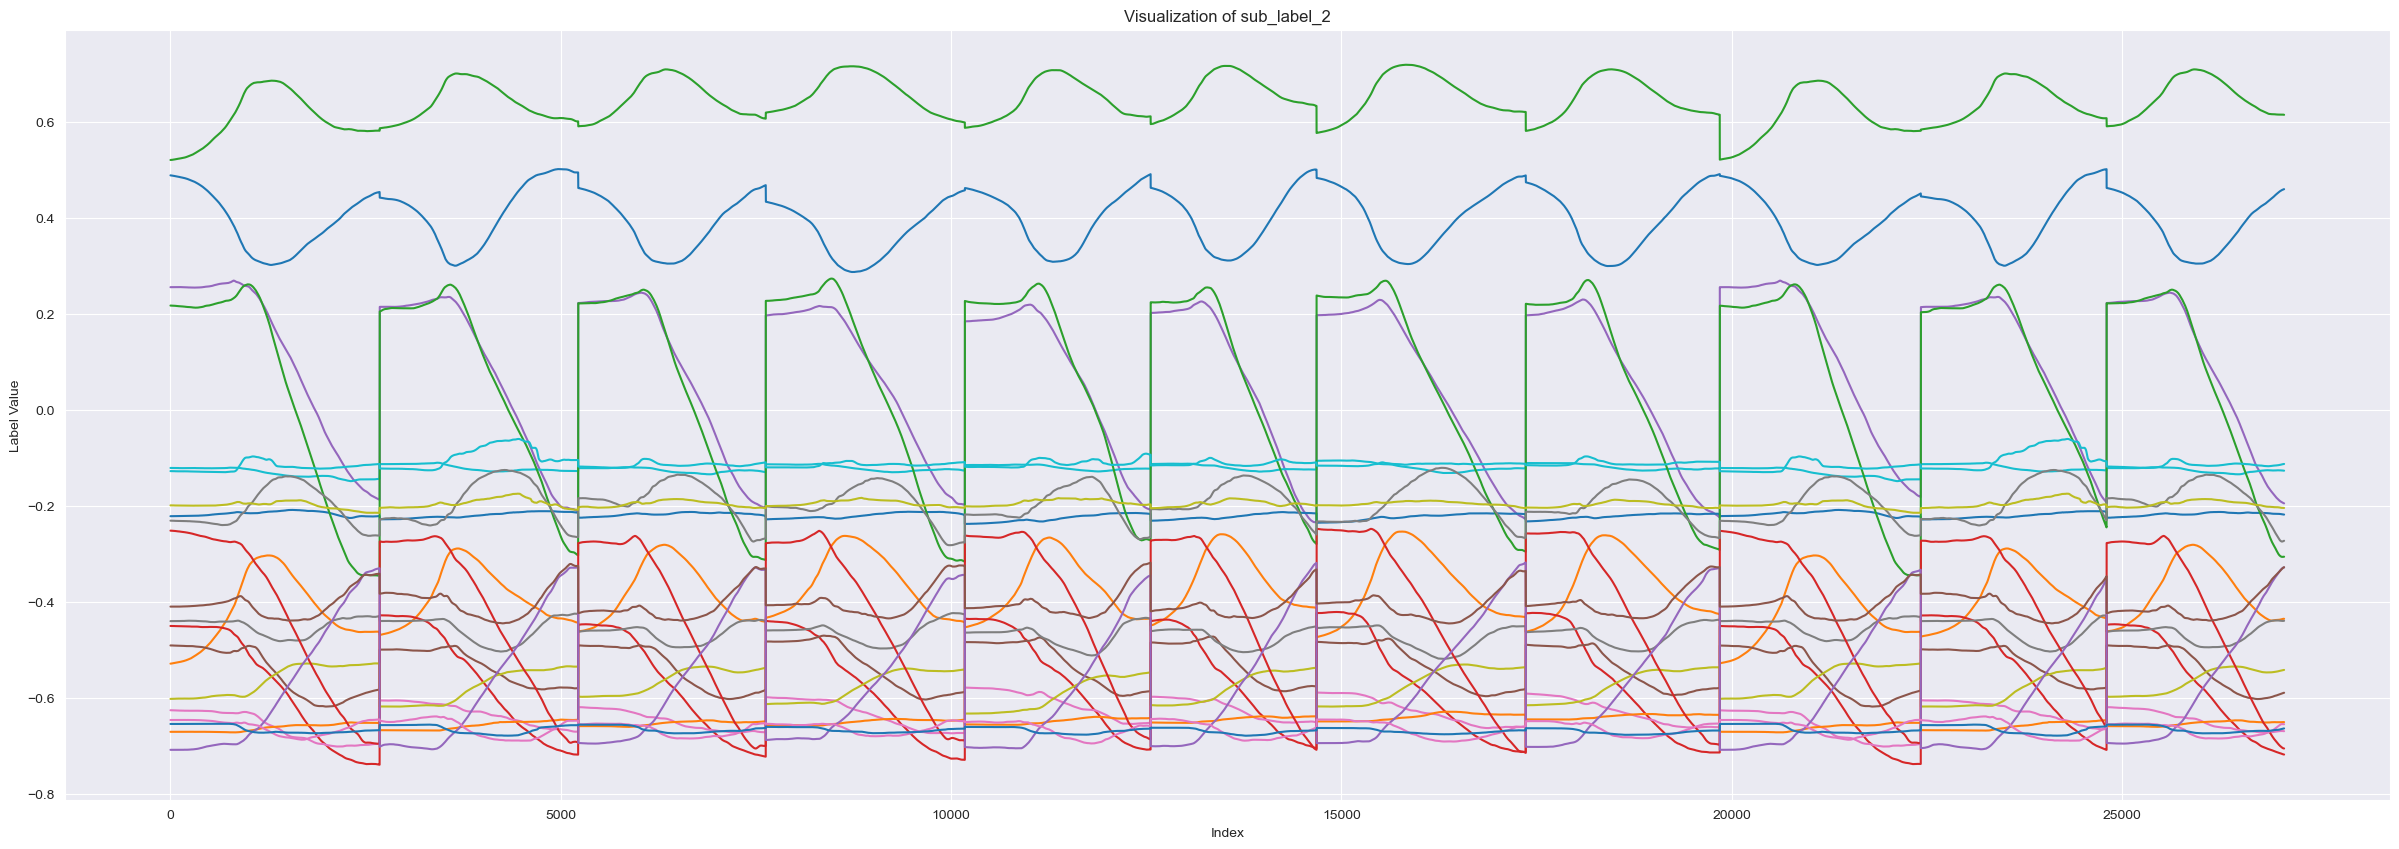

, imu_sample.shape:  (27075, 21)


In [20]:
import matplotlib.pyplot as plt
for sub in range(len(subjects_list_global)):
    subject = subjects_list_global[sub]
    label_phase = []
    sub_emg_sample, sub_emg_sample_left, sub_imu_sample, sub_angle_sample, sub_label_1, sub_label_2 = [], [], [], [], [], []
    printlog(info=''.join(['开始处理： ', subject]), time=True, line_break=False)
    # 读取激活点数据
    activate_point_name = os.path.join(raw_file_path, 'Activate points-phase', 'Normal',
                                       ''.join(['EgP-4-2', '-sittostand.xlsx']))  ##'Health','Left'/Normal
    activate_point = pd.read_excel(activate_point_name, header=None)
    activate_point_name_2 = os.path.join(raw_file_path, 'Activate points-phase', 'Abnormal',
                                         ''.join(['EgP-4-2', '-sittostand.xlsx']))  ##'Health','Left'/Normal
    activate_point_2 = pd.read_excel(activate_point_name_2, header=None)
    # print(activate_point_name)
    # 读取原始数据
    raw_file_name = os.path.join(raw_file_path, 'rawData_npz', ''.join([subject, '.npz']))
    raw_data = np.load(raw_file_name, allow_pickle=True)
    r_data = raw_data['data']
    # print(r_data.shape)
    column_names = raw_data['column_names']
    print(column_names)
    data = np.zeros((int(r_data.shape[0] * target_fs / raw_imu_fs), r_data.shape[1]))  # 使用零初始化
    # 对每一列数据进行重采样
    for col in range(r_data.shape[1]):
        data[:, col] = librosa.resample(r_data[:, col], orig_sr=raw_emg_fs, target_sr=target_fs, res_type='kaiser_best',
                                        scale=False)
    # print(data.shape)
    # 获取时间点

    time_points = activate_point.values.astype('float')
    m, n = time_points.shape
    time_points_2 = activate_point_2.values.astype('float')
    # print(m,n)
    # 遍历每个时间段
    for i in range(0, m):  # 遍历每一行 (每个时间点序列)
        label = []
        for j in range(n - 1):  # 遍历每一列（除了最后一列）
            # imu读取和降采样
            imu_temp = []
            for imu_name in imu_names:
                index = imu_indices[imu_name]
                temp_data = data[int(time_points[i, j] * target_fs):int(time_points[i, j + 1] * target_fs), index]
                imu_temp.append(temp_data)
            imu_data = np.array(imu_temp).T
            sub_imu_sample.extend(imu_data)
    sub_imu_sample = np.array(sub_imu_sample)
    print(sub_imu_sample.shape)

    df = pd.DataFrame(sub_imu_sample, columns=[f'IMU_{i + 1}' for i in range(sub_imu_sample.shape[1])])

    # 保存为 CSV 文件
    df.to_csv('outputEgP-4-2-0226.csv', index=False)

    print("CSV 文件已保存！")
    # 创建一个简单的条形图
    plt.figure(figsize=(30, 10))
    # plt.plot(range(len(sub_angle_sample )), sub_angle_sample )
    plt.plot(range(len(sub_imu_sample)), sub_imu_sample)
    # plt.plot(range(len(sub_imu_sample )),sub_imu_sample  )

    # 设置图形的标题和标签
    plt.title("Visualization of sub_label_2")
    plt.xlabel("Index")
    plt.ylabel("Label Value")

    # 显示图形
    plt.show()
    print(', imu_sample.shape: ', imu_sample.shape)



In [5]:
### 参数设置
## 1. 原始文件路径
raw_file_path = os.path.join(os.getcwd(), 'TJRawData')
## 2. 受试者和运动类型设置
# subjects_list_global = list(['EgH-1','EgH-2','EgH-3','EgH-4','EgH-5','EgH-6','EgH-7'])
subjects_list_global = list(['EgP-4-2'])
# subjects_list_global = list(['EgP-1-2','EgP-2-2','EgP-3-2','EgP-4-2','EgP-5-2','EgP-6-2','EgP-7-2'])  ##'EgP-1-2-44',EgH-2-44
phases_list_global = ['phase 0', 'phase 1', 'phase 2', 'phase 3']
## 3. 所使用的原始数据中emg、IMU和关节角度的文件（列）名
emg_names = ['GLUT. MED. 左,uV', 'VMO 左,uV', 'RECTUS FEM. 左,uV', 'RECTUS FEM. 右,uV', 'BICEPS FEM. 左,uV',
             'BICEPS FEM. 右,uV', 'VMO 右,uV', 'SEMITEND. 右,uV', 'TIB.ANT. 左,uV', 'TIB.ANT. 右,uV',
             'MED. GASTRO 左,uV', 'MED. GASTRO 右,uV', 'SOLEUS 左,uV', 'SOLEUS 右,uV', 'GLUT. MED. 右,uV',
             'SEMITEND. 左,uV']
{'GLUT. MED. 左,uV': 1, 'SEMITEND. 左,uV': 16, 'VMO 左,uV': 2, 'RECTUS FEM. 左,uV': 3, 'BICEPS FEM. 左,uV': 5, 'TIB.ANT. 左,uV': 9, 'MED. GASTRO 左,uV': 11, 'SOLEUS 左,uV': 13, 'GLUT. MED. 右,uV': 15, 'SEMITEND. 右,uV': 8, 'VMO 右,uV': 7, 'RECTUS FEM. 右,uV': 4, 'BICEPS FEM. 右,uV': 6, 'TIB.ANT. 右,uV': 10, 'MED. GASTRO 右,uV': 12, 'SOLEUS 右,uV': 14}
32128)

imu_names = ['骨盆 course,deg', '骨盆 pitch,deg', '骨盆 roll,deg', '大腿 course 左,deg', '大腿 pitch 左,deg',
             '大腿 roll 左,deg', '胫骨 course 左,deg', '胫骨 pitch 左,deg', '胫骨 roll 左,deg', '脚 course 左,deg',
             '脚 pitch 左,deg', '脚 roll 左,deg', '大腿 course 右,deg', '大腿 pitch 右,deg', '大腿 roll 右,deg',
             '胫骨 course 右,deg', '胫骨 pitch 右,deg', '胫骨 roll 右,deg', '脚 course 右,deg', '脚 pitch 右,deg',
             '脚 roll 右,deg']
angle_names = ['髋关节屈曲 左,deg', '髋关节屈曲 右,deg', '膝关节屈曲 左,deg', '膝关节屈曲 右,deg', '踝关节背屈 左,deg',
               '踝关节背屈 右,deg']
emg_indices = {name: idx + 1 for idx, name in enumerate(emg_names)}
imu_indices = {name: idx + 23 for idx, name in enumerate(imu_names)}
# print("ss",emg_indices,imu_indices)
angle_indices = {
    '髋关节屈曲 左,deg': 17,
    '髋关节屈曲 右,deg': 18,
    '膝关节屈曲 左,deg': 19,
    '膝关节屈曲 右,deg': 20,
    '踝关节背屈 左,deg': 21,
    '踝关节背屈 右,deg': 22,
}
# print(angle_indices)
## 4. 由于使用的是post数据，除了归一化不再做多余的处理
# post数据中，EMG信号在20 Hz下进行高通滤波（六阶巴特沃斯），在350 Hz下进行低通滤波（六阶巴特沃斯），在6、60和180 Hz下进行陷波滤波（六阶巴特沃斯，300 Hz宽度），以衰减运动伪影和环境干扰。
# 测角仪和IMU信号分别在10和25 Hz下进行低通滤波（六阶巴特沃斯）。
data_normalize_method = 'positive_negative_one'  # 支持：'min-max' （0-1之间），'max-abs' (-1,1之间)，'positive_negative_one' （-1，1之间）
data_normalize_level = 'rows'  # 'matrix' （矩阵层面，使用整个矩阵的最大值最小值来对每一列进行操作，这样保持了每种模态信号的相对幅值），
# 'rows' （列层面，使用每一列（通道）的最大值最小值来对每一列进行操作，即每一列都被单独归一化）
## 5. 重叠窗口采样：重叠窗长， 步进长度
window, step = 32, 16  ## 重叠长度为：window-step：32-16,64-32,128-64,256-128)
win=32128
## 6. 其他设置
raw_emg_fs = 2000
raw_imu_fs = 2000
target_fs =1000
print(str(win))

32128



================================================================================2025-01-10 15:41:56
开始处理： EgP-4-2
['Time,s' 'GLUT. MED. 左,uV' 'VMO 左,uV' 'RECTUS FEM. 左,uV'
 'RECTUS FEM. 右,uV' 'BICEPS FEM. 左,uV' 'BICEPS FEM. 右,uV' 'VMO 右,uV'
 'SEMITEND. 右,uV' 'TIB.ANT. 左,uV' 'TIB.ANT. 右,uV' 'MED. GASTRO 左,uV'
 'MED. GASTRO 右,uV' 'SOLEUS 左,uV' 'SOLEUS 右,uV' 'GLUT. MED. 右,uV'
 'SEMITEND. 左,uV' '髋关节屈曲 左,deg' '髋关节屈曲 右,deg' '膝关节屈曲 左,deg' '膝关节屈曲 右,deg'
 '踝关节背屈 左,deg' '踝关节背屈 右,deg' '骨盆 course,deg' '骨盆 pitch,deg' '骨盆 roll,deg'
 '大腿 course 左,deg' '大腿 pitch 左,deg' '大腿 roll 左,deg' '胫骨 course 左,deg'
 '胫骨 pitch 左,deg' '胫骨 roll 左,deg' '脚 course 左,deg' '脚 pitch 左,deg'
 '脚 roll 左,deg' '大腿 course 右,deg' '大腿 pitch 右,deg' '大腿 roll 右,deg'
 '胫骨 course 右,deg' '胫骨 pitch 右,deg' '胫骨 roll 右,deg' '骨盆 Rot X,'
 '骨盆 Rot Y,' '骨盆 Rot Z,']
(19846, 16) (19846, 21) (19846, 6) (19846,)
CSV 文件已保存！


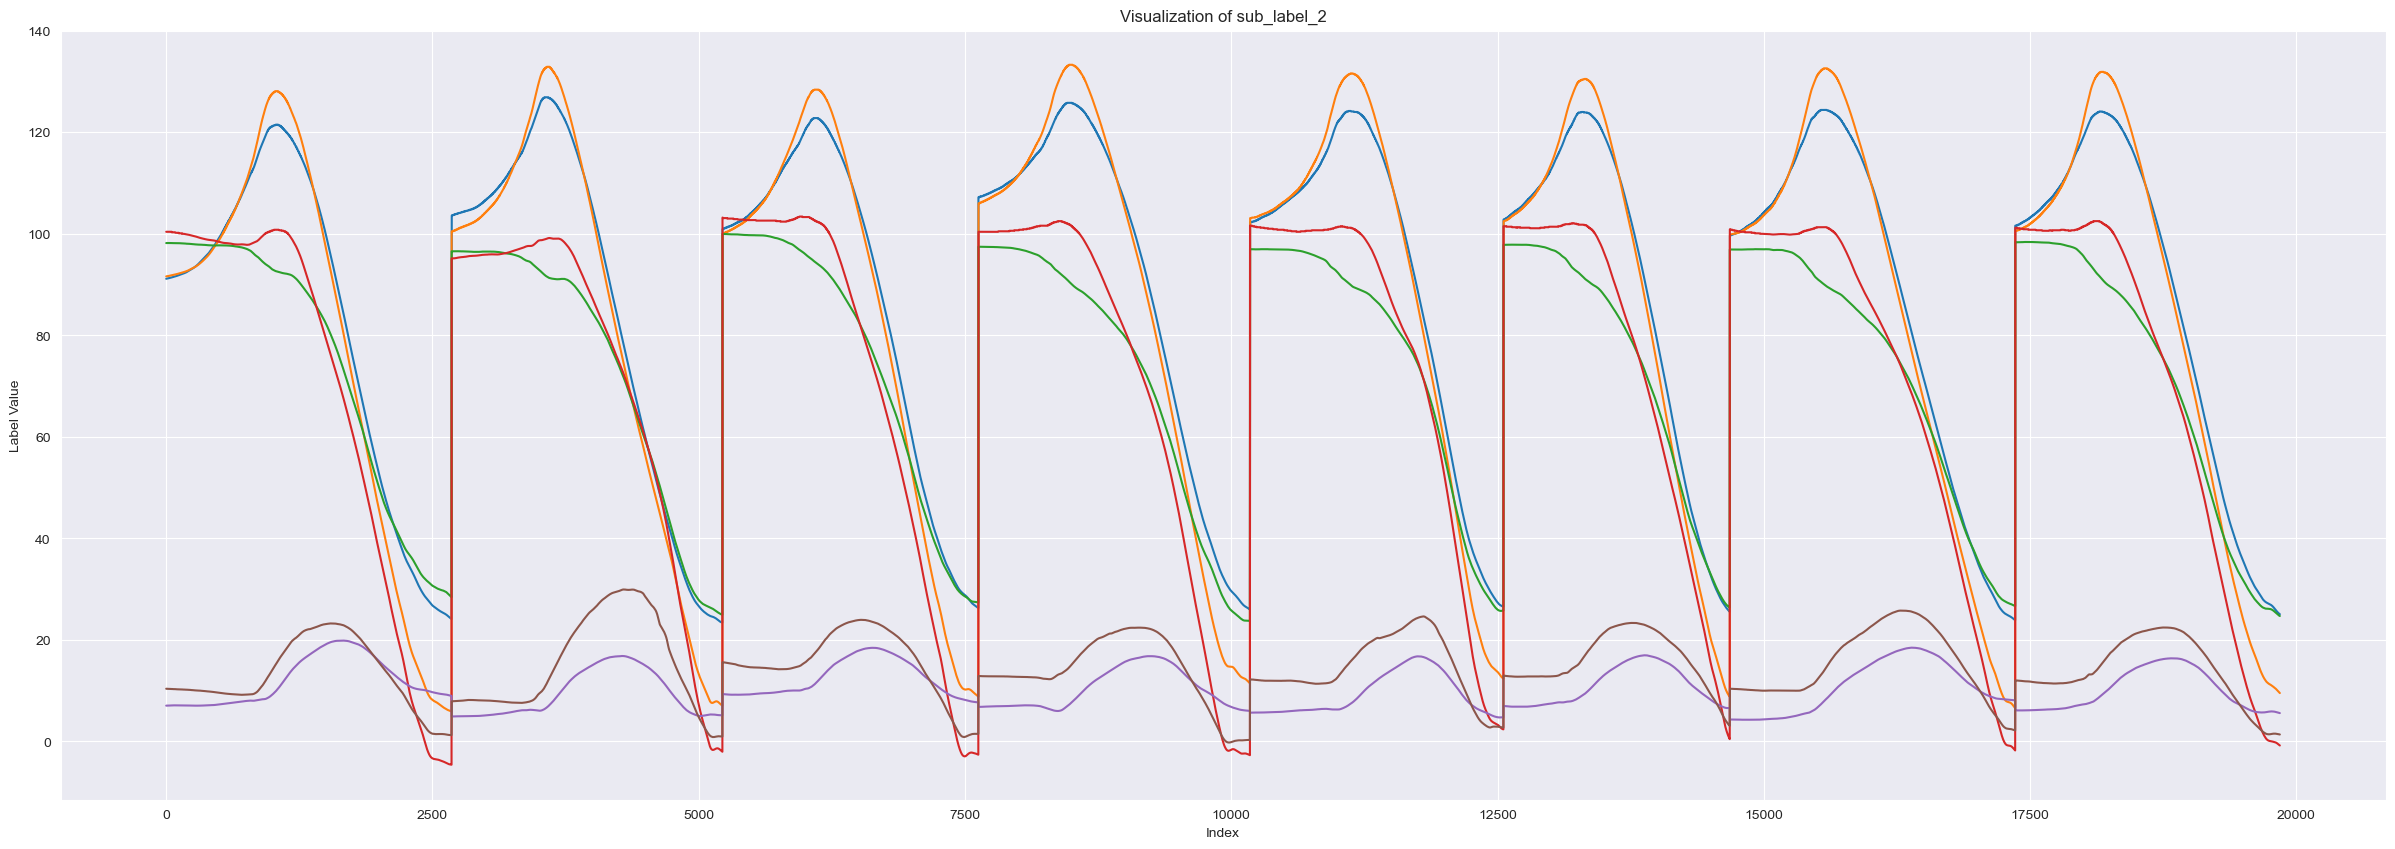

In [6]:
### 处理和保存数据，截取，拼接坐站过程emg，IMU，angle和label，归一化处理，保存角度归一化scalar，滑动窗进行数据分割，得到mg_sample.shape:  (2783, 32, 16) , imu_sample.shape:  (2783, 32, 21) angle_sample.shape:  (2783, 32, 6) , label_1.shape:  (2783, 16, 6) , label_2.shape:  (2783, 1)
import matplotlib.pyplot as plt
for sub in range(len(subjects_list_global)):
    subject = subjects_list_global[sub]
    label_phase = []
    sub_emg_sample, sub_imu_sample, sub_angle_sample, sub_label_1, sub_label_2 = [], [], [], [], []
    printlog(info=''.join(['开始处理： ', subject]), time=True, line_break=False)
    # 读取激活点数据
    activate_point_name = os.path.join(raw_file_path, 'Activate points-phase', 'Normal',''.join([subject, '-sittostand.xlsx']))##'Health','Left'/Normal
    activate_point = pd.read_excel(activate_point_name, header=None)
    activate_point_name_2 = os.path.join(raw_file_path, 'Activate points-phase', 'Abnormal',''.join([subject, '-sittostand.xlsx']))##'Health','Left'/Normal
    activate_point_2 = pd.read_excel(activate_point_name_2, header=None)
    # print(activate_point_name)
     # 读取原始数据
    raw_file_name = os.path.join(raw_file_path, 'rawData_npz', ''.join([subject, '.npz']))
    raw_data = np.load(raw_file_name, allow_pickle=True)
    r_data = raw_data['data']
    # print(r_data.shape)
    column_names = raw_data['column_names']
    print(column_names)
    data = np.zeros((int(r_data.shape[0]*target_fs/raw_imu_fs), r_data.shape[1]))  # 使用零初始化
    # 对每一列数据进行重采样
    for col in range(r_data.shape[1]):
        data[:, col] = librosa.resample(r_data[:, col], orig_sr=raw_emg_fs, target_sr=target_fs, res_type='kaiser_best', scale=False)
    # print(data.shape)
     # 获取时间点

    time_points = activate_point.values.astype('float')
    m,n=time_points.shape
    # print(m,n)
    # 遍历每个时间段
    for i in range(0,m):  # 遍历每一行 (每个时间点序列)
        label = []
        for j in range(n - 1):  # 遍历每一列（除了最后一列）
            # emg读取和降采样
            emg_temp = []
            for emg_name in emg_names:
                index = emg_indices[emg_name]
                temp_data = data[int(time_points[i, j] * target_fs):int(time_points[i, j+1] * target_fs), index]
                emg_temp.append(temp_data)
            emg_data = np.array(emg_temp).T
            # imu读取和降采样
            imu_temp = []
            for imu_name in imu_names:
                index = imu_indices[imu_name]
                temp_data = data[int(time_points[i, j]*target_fs):int(time_points[i, j+1]*target_fs),index]
                imu_temp.append(temp_data)
            imu_data = np.array(imu_temp).T
            # angle读取和降采样
            angle_temp = []
            for angle_name in angle_names:
                index = angle_indices[angle_name]
                temp_data = data[int(time_points[i, j]*target_fs):int(time_points[i, j+1]*target_fs),index]
                angle_temp.append(temp_data)
            angle_data = np.array(angle_temp).T
            # 计算时间差，并转换为样本数
            num = angle_data.shape[0]
            temp_label = [j] * num  # 创建标签数组
            sub_label_2.extend(temp_label)
            sub_emg_sample.extend(emg_data)
            sub_imu_sample.extend(imu_data)
            sub_angle_sample.extend(angle_data)
    sub_emg_sample = np.array(sub_emg_sample)
    sub_imu_sample = np.array(sub_imu_sample)
    sub_angle_sample = np.array(sub_angle_sample)
    sub_label_2 = np.array(sub_label_2)
    print(sub_emg_sample.shape,sub_imu_sample.shape,sub_angle_sample.shape,sub_label_2.shape)

    # 将每个数组转为 DataFrame
    df_emg = pd.DataFrame(sub_emg_sample, columns=[f'EMG_{i+1}' for i in range(sub_emg_sample.shape[1])])
    df_imu = pd.DataFrame(sub_imu_sample, columns=[f'IMU_{i+1}' for i in range(sub_imu_sample.shape[1])])
    df_angle = pd.DataFrame(sub_angle_sample, columns=[f'Angle_{i+1}' for i in range(sub_angle_sample.shape[1])])
    df_label = pd.DataFrame(sub_label_2, columns=['Label'])

    # 合并所有 DataFrame
    df = pd.concat([df_emg, df_imu, df_angle, df_label], axis=1)

    # 保存为 CSV 文件
    df.to_csv('output111.csv', index=False)

    print("CSV 文件已保存！")
    # 创建一个简单的条形图
    plt.figure(figsize=(30, 10))
    # plt.plot(range(len(sub_angle_sample )), sub_angle_sample )
    plt.plot(range(len(sub_angle_sample )),sub_angle_sample )
    # plt.plot(range(len(sub_imu_sample )),sub_imu_sample  )

    # 设置图形的标题和标签
    plt.title("Visualization of sub_label_2")
    plt.xlabel("Index")
    plt.ylabel("Label Value")

    # 显示图形
    plt.show()



Class:, Number of samples: 983
受试者: EgP-1-2数据保存完毕！
E:\PhD\rehabilitation\小论文\论文3\同济坐站角度相位预测\preProcessing\TJtrainData\anglePhasePrediction\window-32128\EgP-1-2_targetTrainData_NoDelete.npz


<Figure size 3000x1000 with 0 Axes>

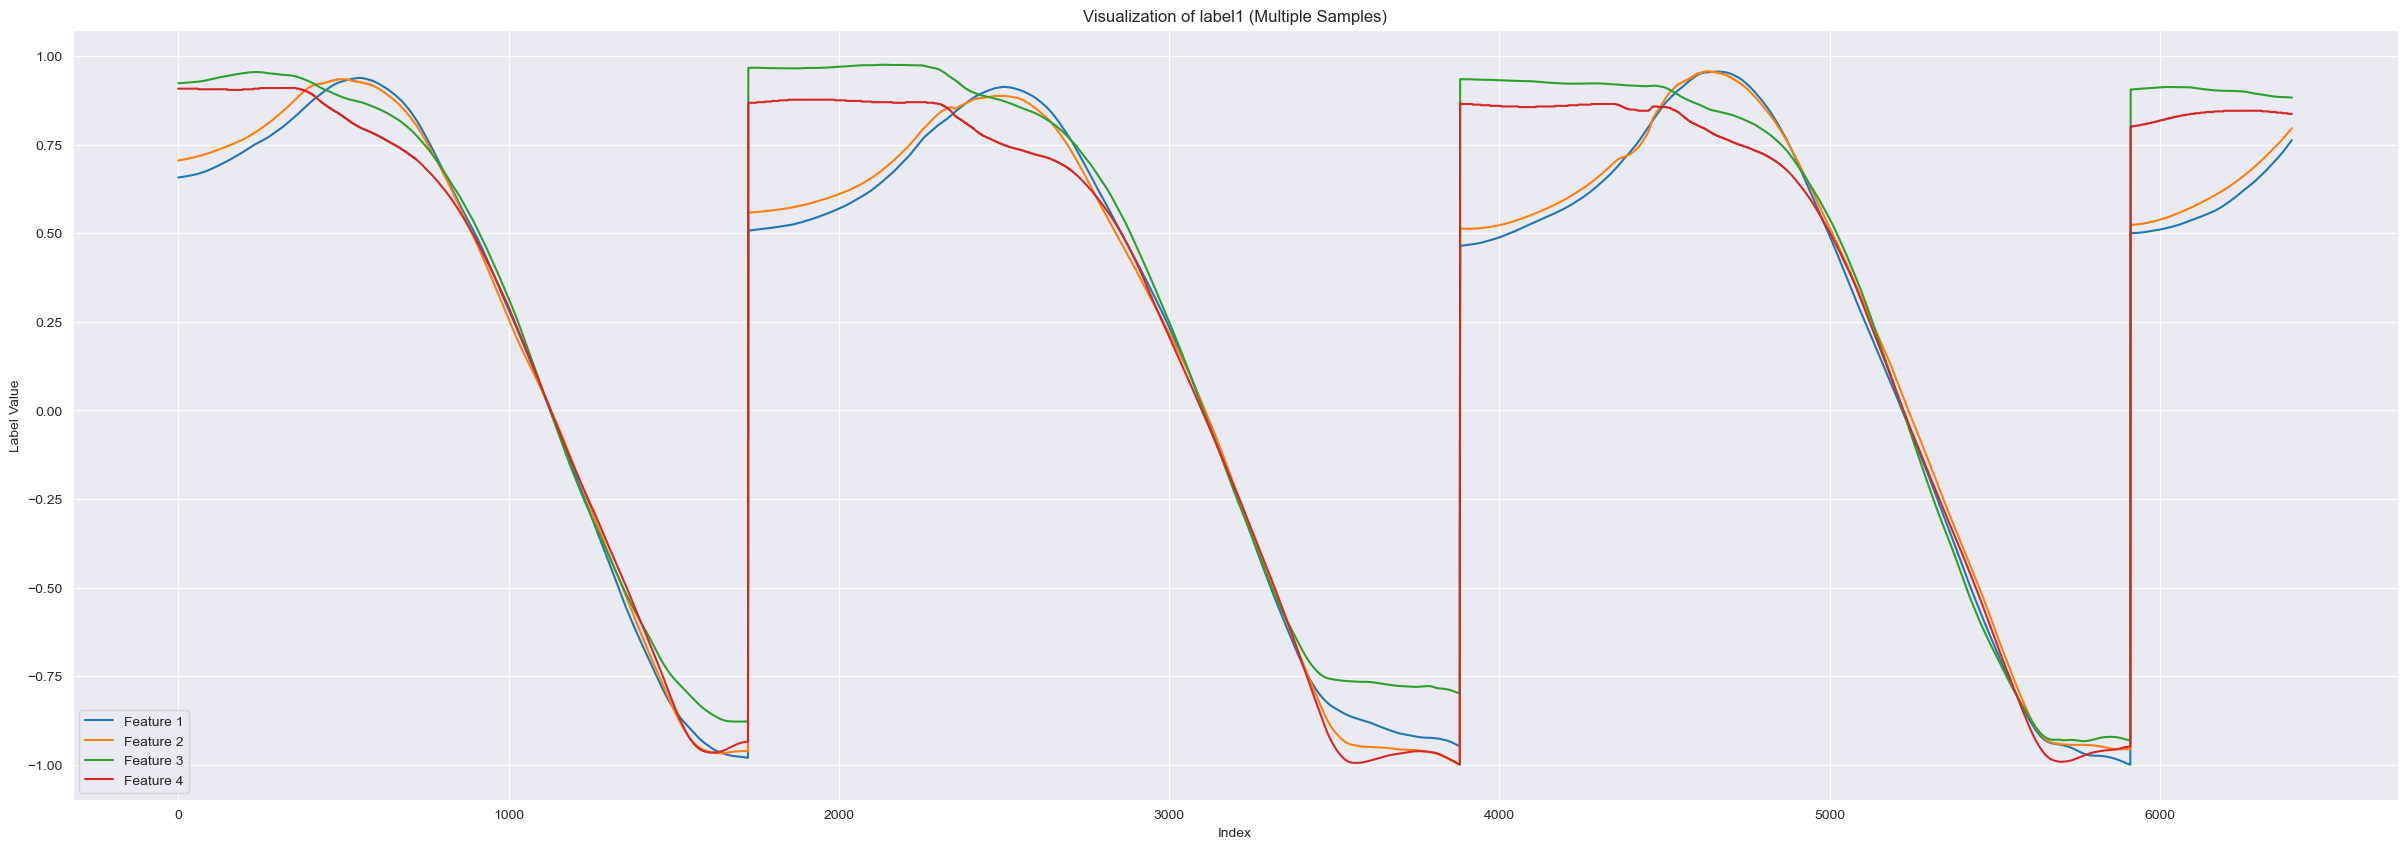

emg_sample.shape:  (983, 32, 16) , imu_sample.shape:  (983, 32, 21)
angle_sample.shape:  (983, 32, 6) , label1.shape:  (983, 16, 4) , label2.shape:  (983, 1)


In [54]:
##数据归一化处理
emg_data_pre,_= data_nomalize(sub_emg_sample, data_normalize_method, data_normalize_level)
imu_data_pre ,_ = data_nomalize(sub_imu_sample, data_normalize_method, data_normalize_level)
# angle_data_pre,scaler  = data_nomalize(sub_angle_sample, data_normalize_method, data_normalize_level)###预测角度没有
# 保存 scaler
angle_data_pre = sub_angle_sample/180
# save_scaler(scaler, subject+'angle_scaler_no_delete.pkl')
emg_sample, imu_sample, angle_sample, label_1,label_2 = tj_movement_classification_sample_segmentation(emg_data_pre, imu_data_pre, angle_data_pre, sub_label_2, window, step,sub_angle_sample, verbose=True)
emg_sample = np.array(emg_sample)
imu_sample = np.array(imu_sample)
angle_sample = np.array(angle_sample)
label1 = np.array(label_1)
label2 = np.array(label_2)  # 确保 label_2 是 一个 numpy 数组
label2 = label2.reshape(-1, 1)  # 重塑 label_2 的形状为 (n_samples, 1)
# ## 获取路径和文件
file_save_path = os.path.join(os.getcwd(), 'TJtrainData', 'anglePhasePrediction', 'window-'+str(win))
make_dir(file_save_path)
file_save_name = os.path.join(file_save_path,''.join([subject, '_targetTrainData_NoDelete.npz']))
## 保存文件
with open(file_save_name, 'wb') as f:
    np.savez(f, emg_sample = emg_sample, imu_sample = imu_sample, angle_sample = angle_sample,
    label1 = label1, label2 = label2, )
printlog(info = ''.join(['受试者: ',subject, '数据保存完毕！']), time = False, line_break = False)
printlog(info = file_save_name, time = False, line_break = False)


# 创建一个简单的条形图
plt.figure(figsize=(30, 10))
# 遍历每个样本
N=400
 # 创建一个简单的条形图
plt.figure(figsize=(30, 10))

# 遍历每个特征维度并绘制
for feature_idx in range(4):  # 遍历每个特征维度
    connected_values = []  # 存储连接后的数据
    # 遍历前 N 个样本
    for sample_idx in range(N):
        connected_values.extend(label1[sample_idx, :, feature_idx])  # 将每个样本的时间步数据连接起来

    # 绘制每个特征维度的曲线
    plt.plot(range(len(connected_values)), connected_values, label=f'Feature {feature_idx + 1}', linestyle='-')

# 设置图形的标题和标签
plt.title("Visualization of label1 (Multiple Samples)")
plt.xlabel("Index")
plt.ylabel("Label Value")
plt.legend()

# 显示图形
plt.show()

# 打印每个数据的形状
print('emg_sample.shape: ', emg_sample.shape, ', imu_sample.shape: ', imu_sample.shape)
print('angle_sample.shape: ', angle_sample.shape, ', label1.shape: ', label1.shape, ', label2.shape: ', label2.shape)

    #  # ## 获取路径和文件
    # file_save_path = os.path.join(os.getcwd(), 'TJtrainData', 'anglePhasePrediction', 'window-'+str(win))
    # make_dir(file_save_path)
    # file_save_name = os.path.join(file_save_path,''.join([subject, '_targetTrainData.npz']))
    # ## 保存文件
    # with open(file_save_name, 'wb') as f:
    #     np.savez(f, emg_sample = emg_sample, imu_sample = imu_sample, angle_sample = angle_sample,
    #     label1 = label1, label2 = label2, )
    # printlog(info = ''.join(['受试者: ',subject, '数据保存完毕！']), time = False, line_break = False)
    # printlog(info = file_save_name, time = False, line_break = False)

In [55]:
import numpy as np
from sklearn.model_selection import KFold

# 合并数据，划分数据集
input_data = np.concatenate((emg_sample, imu_sample), axis=2)  # 共16+21=37通道
angle_labels = label_1
phase_labels = label_2

# 获取数据集的样本数量
test_ratio = 0.2
n_repeats = 1  # 进行3次重复划分
sss = StratifiedShuffleSplit(n_splits=n_repeats, test_size=test_ratio, random_state=42)
for train_index, test_index in sss.split(input_data, phase_labels):
    train_input_data, train_angle_labels, train_phase_labels = input_data[train_index],angle_labels[train_index], phase_labels[train_index]
    test_input_data, test_angle_labels, test_phase_labels = input_data[test_index],angle_labels[test_index], phase_labels[test_index]
    # 输出训练集和测试集的大小
    print(f"  Train size: {len(train_input_data)}")
    print(f"  Test size: {len(test_input_data)}")
    print(f"  Train input data shape: {train_input_data.shape}")
    print(f"  Train angle labels shape: {train_angle_labels.shape}")
    print(f"  Train phase labels shape: {train_phase_labels.shape}")
    print(f"  Test input data shape: {test_input_data.shape}")
    print(f"  Test angle labels shape: {test_angle_labels.shape}")
    print(f"  Test phase labels shape: {test_phase_labels.shape}")
# 确保所有变量是 numpy 数组
train_input_data = np.array(train_input_data)
train_angle_labels = np.array(train_angle_labels)
train_phase_labels = np.array(train_phase_labels)
train_phase_labels =train_phase_labels.reshape(-1,1)
test_input_data = np.array(test_input_data)
test_angle_labels = np.array(test_angle_labels)
test_phase_labels = np.array(test_phase_labels)
test_phase_labels =test_phase_labels.reshape(-1,1)

print(type(train_input_data),type(train_angle_labels),type(train_phase_labels))  # 检查变量类型
print(type(test_input_data ),type(test_angle_labels ),type(test_phase_labels ))  # 检查变量类型
# 保存训练数据
train_data_file = './TJtrainData/anglePhasePrediction/window-32128/train_data_1.npz'
np.savez(train_data_file,
         data=train_input_data,
         label1=train_angle_labels,
         label2=train_phase_labels)

# 保存测试数据
test_data_file = './TJtrainData/anglePhasePrediction/window-32128/test_data_1.npz'
np.savez(test_data_file,
         data=test_input_data,
         label1=test_angle_labels,
         label2=test_phase_labels)
print("保存成功")

  Train size: 786
  Test size: 197
  Train input data shape: (786, 32, 37)
  Train angle labels shape: (786, 16, 4)
  Train phase labels shape: (786,)
  Test input data shape: (197, 32, 37)
  Test angle labels shape: (197, 16, 4)
  Test phase labels shape: (197,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
保存成功
